## import modules

In [1]:
from sklearn.linear_model import Lasso
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from mikit.compname import ChemFormula
from mikit.feature import CreateFeature
from mikit.mlops import WrapperMethod

## Creating molar ratio

In [2]:
# loading csv
path = "./data/learning.csv"
df = pd.read_csv(path)
comp, sigma = df["X"].values, df["Y"].values

# creating moler ratio
cn = ChemFormula()

# all, only F, not F
all_molratio = cn.get_molratio(comp)
f_molratio = cn.get_molratio(comp, tar_atoms=["F"])
cation_molratio = cn.get_molratio(comp, exc_atoms=["F"])

# creating molratio(dict)
dict_molratio = {
    "All" : all_molratio,
    "F" : f_molratio,
    "Cation" : cation_molratio
    }

## Creating features

In [3]:
# creating features of composition
cf = CreateFeature()

# get average features
dict_feature = cf.get_ave_features(dict_molratio)

# adding std features
dict_feature.update(cf.get_std_features(dict_molratio, exc=["F", "All"]))

# adding max features
dict_feature.update(cf.get_max_features(dict_molratio, exc=["F"]))

# adding min features
dict_feature.update(cf.get_min_features(dict_molratio, exc=["F"]))

# creating a new feature
dict_feature["Cation(Ave)/F(Ave)"] = dict_feature["Cation(Ave)"] / dict_feature["F(Ave)"]
dict_feature["All(Max)/F(Ave)"] = dict_feature["All(Max)"] / dict_feature["F(Ave)"]
dict_feature["All(Min)/F(Ave)"] = dict_feature["All(Min)"] / dict_feature["F(Ave)"]

# deleting a feature
del dict_feature["All(Max)"], dict_feature["All(Min)"], dict_feature["F(Ave)"]

# checking a features
print(dict_feature.keys())


dict_keys(['All(Ave)', 'Cation(Ave)', 'Cation(Std)', 'Cation(Max)', 'Cation(Min)', 'Cation(Ave)/F(Ave)', 'All(Max)/F(Ave)', 'All(Min)/F(Ave)'])


## Combining features

In [4]:
# creating dataframe of learnning
df = cf.get_df_learning(dict_feature, comp)

## Wrapper Method

In [5]:
# feature engneering using Wrapper Method
wm = WrapperMethod(X = df.values, y=sigma, feature_names=df.columns.values)
# Lasso
hyper_params = {
    'alpha':[0, 0.2, 0.4, 0.6, 0.8,1.0]
}
model = Lasso()
best_params_idx, scores, best_model = wm.calc_forward(model, hyper_params)

100%|██████████| 146/146 [00:06<00:00, 23.13it/s]


## Output of feature names

In [6]:
df.columns.values[best_params_idx]
df = df[df.columns.values[best_params_idx]]
df.to_pickle("./data/df_learning_lasso.pkl")

## Learnning rate

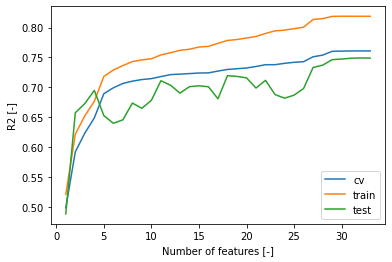

In [7]:
# plot
x = range(1,len(best_params_idx)+1)
plt.plot(x, scores["cv"], label="cv")
plt.plot(x, scores["train"], label="train")
plt.plot(x, scores["test"], label="test")
plt.xlabel("Number of features [-]")
plt.ylabel("R2 [-]")
plt.legend(loc='lower right')
plt.show()

## Saving model

In [8]:
import pickle
pickle.dump(best_model, open("./data/lasso_model.sav", 'wb'))